In [135]:
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import geohash
import numpy as np
import cartopy.crs as ccrs
import pandas as pd
import json

## Parse / Scraping Station data

In [111]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup

### Scraping Starlink Gateway Data

The site https://satellitemap.space/ hosts a crowd-sourced map of Starlink gateways (among other things). As of 2023-03-09, we can extract the basestations depicted in this website by saving the `basestation.json` file from the network traffics. In the firefox browser, we can copy the `basestation.json` from the network traffix log. Below we display the content of that file.

The `desc`, coordinates `lat`&`lng`, and maybe `town` is the most interesting. It is not clear to me currently, where the `status` attribute comes from.

In [221]:
# Manually written logic to classify basestation sources
def tag_sourcetype(row):
    desc = row["desc"]
    if("fcc.report" in desc
        or "web.acma.gov.au" in desc
        or "rrf.rsm.govt.nz" in desc):
        row["srctype"] = "filing"
    elif("whatdotheyknow.com" in desc
        or "arcep.fr" in desc
        or "legales.elmostrador.cl" in desc
        or "bip.uke.gov.pl" in desc):
        row["srctype"] = "filing2"
    else:
        row["srctype"] = "crowdsourced"
        
# removed from elif: or "t.me" in desc
# We can't really say that the information from the PermessiBot is traceable from
# an official public document because I can't find anything linked in the telegram bot message

In [222]:
with open("data/gsdata/satellitemap_basestations.json", "r") as bs_file:
    basestation_json = json.loads(bs_file.read())

basestations = basestation_json["basestations"]
for b in basestations:
    tag_sourcetype(b)
slgs_df = pd.DataFrame.from_dict(basestations)
slgs_df.rename(columns={'lng':'long'}, inplace=True)
slgs_df

,town,desc,lat,long,cc,fd,td,dg,fdd,tdd,dgd,status,srctype,d,url
0,Conrad MT,Antenna count: 8<br>Antenna diameter: 5 feet<b...,48.203306,-111.945278,US,2019-07-17,2019-11-05,2020-03-04,882.0,771.0,651.0,active,filing,NaN,NaN
1,Loring ME,Antenna count: 8<br>Antenna diameter: 5 feet<b...,46.914917,-67.919528,US,2019-09-24,2020-01-08,,813.0,707.0,0.0,active,filing,NaN,NaN
2,Redmond WA,Antenna count: 8<br>Antenna diameter: 5 feet<b...,47.694194,-122.032139,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
3,Greenville PA,Antenna count: 8<br>Antenna diameter: 5 feet<b...,41.433556,-80.333222,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
4,Merrillan WI,"<img src=""https://doc-10-78-mymaps.googleuserc...",44.406333,-90.814278,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,"Ibi, Alicante","Feedback received, exact location/status unknown.",38.630700,-0.544700,ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN
112,"Lepe, Huelva","Feedback received, exact location/status unkniwn.",37.257200,-7.203300,ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN
113,Foggia,Approximate. State Road 554. See permessibot t...,41.507306,15.585439,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,filing2,NaN,NaN
114,"Petrosino, Marsala",Approximate. See permissibot telegram note htt...,37.711000,12.487900,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,filing2,NaN,NaN


In [223]:
# Starlink Availability scraped from wikipedia

from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)

> Why scraping from wikipedia and not from the starlink website directly?

To the best of our knowledge, there is no direct way to get access on a list of accessibility of a country. The [website](https://www.starlink.com/map) shows a map of availabilities, but not directly scrapeable list. Api endpoints of [prices.json](https://api.starlink.com/public-files/prices.json) shows prices for each country and api endpoint [coverage_residential.json](https://api.starlink.com/public-files/coverage_residential.json) shows, I'm assuming, polygon data for the map rendering of availabilities. Getting the country name form the polygon data is non-trivial and the prices list do not guarantee that Starlink is in fact available in that country, only that there exists a price out there.

### Scraping SatNOGS data

In [119]:
# Very rough scraper, does not scraper frequency data which might be interesting at some point

df_dict = {
    "names": [],
    "lat": [],
    "long": [],
    "altitudes_m": [],
    "minelevations_deg": []
}

table_query_str = "https://network.satnogs.org/stations/?testing=0&offline=0&future=0&freq=&page={}"
station_query_str = "https://network.satnogs.org{}"

for i in range(14):
    idx = i+1
    print("Parse page:", idx)
    
    resp = requests.get(query_str.format(idx))
    soup = BeautifulSoup(resp.text)
    gstable = soup.find("table")
    rows = gstable.find_all("tr")
    
    for row in tqdm(rows):
        resp = requests.get(station_query_str.format(row["data-href"]))
        soup = BeautifulSoup(resp.text)

        # Name
        name = soup.find("h2").text.strip()
        df_dict["names"].append(name)

        rowarray = soup.find("tbody").find_all("tr")

        # Coordinates
        coords_str = rowarray[2].find_all("td")[1].text.strip()
        lat_str, lon_str = coords_str.split(",")
        lat = float(lat_str[:-1])
        lon = float(lon_str[:-1])
        df_dict["lat"].append(lat)
        df_dict["long"].append(lon)

        # Altitude in meter
        altitude_m = rowarray[3].find_all("td")[1].text.strip().split(" ")[0]
        df_dict["altitudes_m"].append(altitude_m)

        # Min Elevation in deg
        minelevation_deg = rowarray[4].find_all("td")[1].text.strip().split("°")[0]
        df_dict["minelevations_deg"].append(minelevation_deg)

df = pd.DataFrame(df_dict)
df

Parse page: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Parse page: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50it/s]


Parse page: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.49it/s]


Parse page: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


Parse page: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


Parse page: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


Parse page: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]


Parse page: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Parse page: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


Parse page: 10


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Parse page: 11


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Parse page: 12


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Parse page: 13


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.12it/s]


Parse page: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.07it/s]


,names,lat,long,altitudes_m,minelevations_deg
0,2 - KB9JHU,39.236,-86.305,280,5
1,6 - Apomahon,38.048,23.739,119,20
2,9 - Talos,35.501,24.011,82,15
3,12 - W2BFJ,42.744,-71.538,67,4
4,21 - Avia,36.961,22.145,45,45
...,...,...,...,...,...
262,3022 - propulsion.industries,20.725,-103.423,1595,10
263,3024 - Drachten S-band,53.109,6.108,6,10
264,3027 - WH6GVF VHF,19.415,-154.892,15,5
265,3035 - DO7OO WHQ,53.046,8.891,9,5


In [120]:
df.to_csv("data/gsdata/gsdata_satnog.csv")

## Plotting GSaaS Map

In [121]:
# https://network.satnogs.org/stations/
# Scraped, see code above
gsdata_satnog = pd.read_csv("data/gsdata/gsdata_satnog.csv")

# https://www.ksat.no/ground-network-services/the-ksat-global-ground-station-network/
# Accessed: 2023-03-08
gsdata_ksat   = pd.read_csv("data/gsdata/gsdata_ksat.csv")

# https://atlasground.com/wp-content/uploads/2022/12/WEB-120522-Antenna-Network-Map.pdf
# Accessed: 2023-03-09
gsdata_atlas  = pd.read_csv("data/gsdata/gsdata_atlas.csv")

# https://leaf.space/
# Accessed: 2023-03-09
gsdata_leaf   = pd.read_csv("data/gsdata/gsdata_leaf.csv")

# Azure
# https://azure.microsoft.com/en-us/products/orbital/

In [168]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


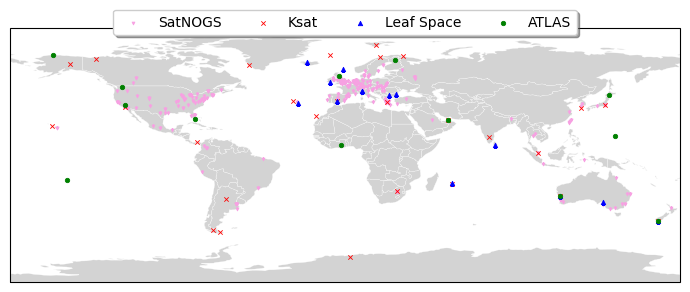

In [225]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "lightgrey", edgecolor="white", ax=ax, linewidth=0.2)

# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = 0.6,
               label=label)

plot_gsdata(gsdata_satnog, ax, "SatNOGS", "v", "#f7a1e2", 4)
plot_gsdata(gsdata_ksat, ax, "Ksat", "x", "red")
plot_gsdata(gsdata_leaf, ax, "Leaf Space", "^", "blue")
plot_gsdata(gsdata_atlas, ax, "ATLAS", "o", "green")

    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.legend(loc = "lower left")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=4, fancybox=True, shadow=True)

plt.axis('tight')
plt.tight_layout()
#plt.axis('tight')
plt.savefig("figures/gs_services.pdf", pad_inches=0)
plt.show()

## Plotting Starlink Gateway Map

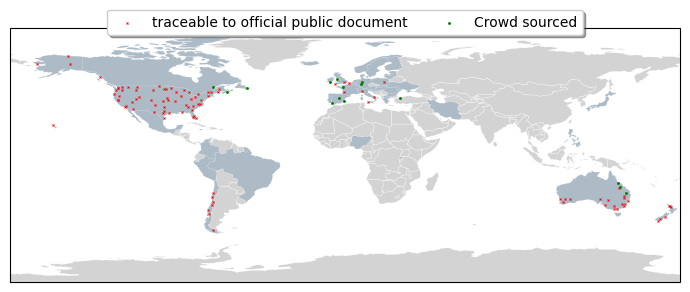

In [224]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "lightgrey", edgecolor="white", ax=ax, linewidth=0.2)

# Plot Country Patches where a Starlink is available
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))
for c in countries:
    c = "United States of America" if c == "United States" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, cols[2])

# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = 0.6,
               label=label)
    
#plot_gsdata(gsdata_satnog, ax, "SatNOGS", "v", "#f7a1e2", 4)
plot_gsdata(slgs_df[(slgs_df["srctype"] == "filing") | (slgs_df["srctype"] == "filing2")],
            ax, "traceable to official public document", "x", "red", size=2)
#plot_gsdata(slgs_df[slgs_df["srctype"] == "filing2"],
#            ax, "Ksat", "x", "blue", size=2)
plot_gsdata(slgs_df[slgs_df["srctype"] == "crowdsourced"],
            ax, "Crowd sourced", "o", "green", size=2)
#plot_gsdata(gsdata_leaf, ax, "Leaf Space", "^", "blue")
#plot_gsdata(gsdata_atlas, ax, "ATLAS", "o", "green")


    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.legend(loc = "lower left")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=4, fancybox=True, shadow=True)

plt.axis('tight')
plt.tight_layout()
plt.savefig("figures/starlink_gws.pdf", pad_inches=0)
plt.show()